In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from geopy.geocoders import Nominatim
from translate import Translator
import seaborn as sns
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
# View all the files in the data folder; 
root_path = "C:\\Users\\Solar\\Furiends\\Furiends\\data\\raw\\Fake Data1"
os.listdir(root_path)

['Activity.csv',
 'Community_Table.csv',
 'Log_Table.csv',
 'Pets_Table.csv',
 'pet_category_table.csv',
 'User_Table.csv']

## Data Loading

In [3]:
# Load data and view
activity_data = pd.read_csv(os.path.join(root_path, 'Activity.csv'))
activity_data = activity_data.loc[:, ~activity_data.columns.str.match("Unnamed")]
print("Activity data: ")
display(activity_data.head())
print(activity_data.shape)

community_data = pd.read_csv(os.path.join(root_path, 'Community_Table.csv'))
community_data = community_data.loc[:, ~community_data.columns.str.match("Unnamed")]
print("Community data: ")
display(community_data.head())
print(community_data.shape)

log_data = pd.read_csv(os.path.join(root_path, 'Log_Table.csv'))
log_data = log_data.loc[:, ~log_data.columns.str.match("Unnamed")]
print("Log data: ")
display(log_data.head())
print(log_data.shape)

pets_data = pd.read_csv(os.path.join(root_path, 'Pets_Table.csv'))
pets_data = pets_data.loc[:, ~pets_data.columns.str.match("Unnamed")]
print("Pets data: ")
display(pets_data.head())
print(pets_data.shape)

pet_cat_data = pd.read_csv(os.path.join(root_path,  'pet_category_table.csv'))
pet_cat_data = pet_cat_data.loc[:, ~pet_cat_data.columns.str.match("Unnamed")]
print("Pets categoriy data: ")
display(pet_cat_data.head())
print(pet_cat_data.shape)

user_data = pd.read_csv(os.path.join(root_path, 'User_Table.csv'))
user_data = user_data.loc[:, ~user_data.columns.str.match("Unnamed")]
print("User data: ")
display(user_data.head())
print(user_data.shape)

Activity data: 


,Activity_Id,fk_User_id,fk_Pet_id,VR_loading_time,duration_activity,log_id_act
0,1,25,157,91.4,8.3,444
1,2,287,131,19.0,0.5,105
2,3,192,285,100.2,2.9,687
3,4,237,292,108.3,2.1,1728
4,5,128,189,116.1,5.7,1235


(2873, 6)
Community data: 


,comm_User_id,Request_time,Sharing_Votes,Clicking_Votes,New_Friends_Invite,Activity_id
0,60,2020-05-15 09:17:37,10,7,3,1
1,217,2022-05-01 04:47:57,6,9,3,2
2,11,2020-11-18 18:22:42,7,2,4,3
3,248,2022-12-31 12:22:11,6,10,4,4
4,86,2021-01-19 10:13:16,8,7,10,5


(1000, 6)
Log data: 


,log_user_id,Logging_IN_time,IOT_TYPE,Log_id
0,145,2021-10-09 09:19:03,'PC',1
1,219,2021-01-30 18:48:51,‘Mobile’,2
2,264,2022-08-15 16:44:43,‘Mobile’,3
3,217,2021-03-04 01:32:35,'PC',4
4,274,2022-07-11 00:55:06,'PC',5


(3000, 4)
Pets data: 


,Pet_id,pet_User_id,Pet_Name,Pet_intimacy,Pets_category
0,1,187,Khalil Jenkins,7.0,4
1,2,71,Conrad Ratke PhD,7.6,1
2,3,129,Mr. Arnulfo Beahan,2.2,2
3,4,193,Michele Jacobs,0.8,1
4,5,228,Mrs. Hannah Bartoletti,9.0,2


(350, 5)
Pets categoriy data: 


,category_id,category_name
0,1,'Bulldog'
1,2,'Golden Retriever'
2,3,'Shi-ba-inu'
3,4,'Maltese'
4,5,'German Shepherd'


(6, 2)
User data: 


,User_id,First_Name,Last_Name,Address,Age,Gender,Rehabilitation
0,1,Aiden,Hodkiewicz,"34795 Modesta Vista Suite 993\r\nEast Bailey, ...",26,1,1
1,2,Verla,Paucek,"668 Alisha Port\r\nAniyamouth, PA 99186-1643",52,2,1
2,3,Richmond,Kovacek,"2659 Maia Islands Apt. 381\r\nPort Elmore, UT ...",31,2,2
3,4,Jeromy,Schmitt,20035 Effertz Viaduct Suite 786\r\nGutmannvill...,72,1,1
4,5,Kailey,Ankunding,"7774 Clint Row Suite 134\r\nGrimesfurt, PA 71486",25,2,1


(300, 7)


## Data Preprocessing

In [7]:
user_data["Zipcode"] = user_data["Address"].str.split(", ").str.get(-1).str.split(" ").str.get(-1).str[:5]

,User_id,First_Name,Last_Name,Address,Age,Gender,Rehabilitation,Zipcode
0,1,Aiden,Hodkiewicz,"34795 Modesta Vista Suite 993\r\nEast Bailey, ...",26,1,1,26547
1,2,Verla,Paucek,"668 Alisha Port\r\nAniyamouth, PA 99186-1643",52,2,1,99186
2,3,Richmond,Kovacek,"2659 Maia Islands Apt. 381\r\nPort Elmore, UT ...",31,2,2,65406
3,4,Jeromy,Schmitt,20035 Effertz Viaduct Suite 786\r\nGutmannvill...,72,1,1,10687
4,5,Kailey,Ankunding,"7774 Clint Row Suite 134\r\nGrimesfurt, PA 71486",25,2,1,71486
...,...,...,...,...,...,...,...,...
295,296,Sydney,Langworth,"93049 Dicki Viaduct Apt. 514\r\nNorth Marlene,...",82,2,2,64335
296,297,Constantin,Koss,"820 Beahan Islands Suite 917\r\nPort Beatrice,...",81,2,1,73899
297,298,Annabell,Schmidt,"3744 Shanelle Courts Suite 457\r\nRathshire, W...",53,2,1,93390
298,299,Stanton,Grimes,"062 Morissette Gardens\r\nXzavierton, MN 53070...",47,1,2,53070


In [8]:
# get the country name using zipcode
geolocator = Nominatim(user_agent="geoapiExercises")
def get_country(zipcode):
    try:
        country = geolocator.geocode(zipcode, language='en').address.split(',')[-1]
        return country
    except AttributeError:
        return None
user_data["Country"] = user_data.loc[:, "Zipcode"].apply(lambda x: get_country(x))

In [10]:
user_data

,User_id,First_Name,Last_Name,Address,Age,Gender,Rehabilitation,Zipcode,Country,Country_abbrev,Continent
0,1,Aiden,Hodkiewicz,"34795 Modesta Vista Suite 993\r\nEast Bailey, ...",26,1,1,26547,United States,US,NA
1,2,Verla,Paucek,"668 Alisha Port\r\nAniyamouth, PA 99186-1643",52,2,1,99186,Lithuania,LT,EU
2,3,Richmond,Kovacek,"2659 Maia Islands Apt. 381\r\nPort Elmore, UT ...",31,2,2,65406,Estonia,EE,EU
4,5,Kailey,Ankunding,"7774 Clint Row Suite 134\r\nGrimesfurt, PA 71486",25,2,1,71486,United States,US,NA
5,6,Sally,Langosh,"1995 August Locks\r\nGutkowskiborough, OK 1600...",63,2,2,16002,South Korea,KR,AS
...,...,...,...,...,...,...,...,...,...,...,...
295,296,Sydney,Langworth,"93049 Dicki Viaduct Apt. 514\r\nNorth Marlene,...",82,2,2,64335,Poland,PL,EU
296,297,Constantin,Koss,"820 Beahan Islands Suite 917\r\nPort Beatrice,...",81,2,1,73899,Italy,IT,EU
297,298,Annabell,Schmidt,"3744 Shanelle Courts Suite 457\r\nRathshire, W...",53,2,1,93390,France,FR,EU
298,299,Stanton,Grimes,"062 Morissette Gardens\r\nXzavierton, MN 53070...",47,1,2,53070,United States,US,NA


In [9]:
def get_continent(col):
    try:
        col = col.strip()
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_continent)

user_data = user_data.loc[user_data.loc[:,"Country"].str.isnumeric() == False]
user_data["Country_abbrev"] = user_data.loc[:, "Country"].apply(lambda x: get_continent(x)[0])
user_data["Continent"] = user_data.loc[:, "Country"].apply(lambda x: get_continent(x)[1])

C:\Users\Solar\AppData\Local\Temp\ipykernel_17404\1046332796.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data["Country_abbrev"] = user_data.loc[:, "Country"].apply(lambda x: get_continent(x)[0])
C:\Users\Solar\AppData\Local\Temp\ipykernel_17404\1046332796.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data["Continent"] = user_data.loc[:, "Country"].apply(lambda x: get_continent(x)[1])


In [11]:
# Check if there are incorrect data
display(log_data["IOT_TYPE"].value_counts())
display(user_data.describe())

'PC'        1524
‘Mobile’    1476
Name: IOT_TYPE, dtype: int64

,User_id,Age,Gender,Rehabilitation
count,283.000000,283.000000,283.000000,283.000000
mean,151.325088,48.590106,1.466431,1.540636
std,87.270186,22.876515,0.499756,0.499229
min,1.000000,12.000000,1.000000,1.000000
25%,75.500000,28.000000,1.000000,1.000000
50%,151.000000,47.000000,1.000000,2.000000
75%,228.500000,68.000000,2.000000,2.000000
max,300.000000,89.000000,2.000000,2.000000


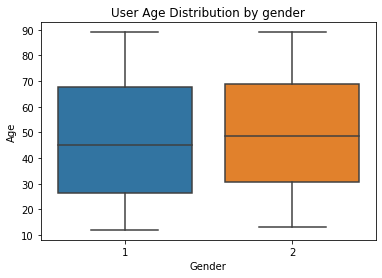

In [12]:
# View the data distribution
sns.boxplot(data=user_data, y="Age", x="Gender")
plt.title("User Age Distribution by gender")
plt.show()

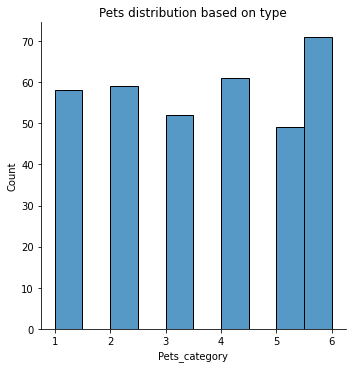

In [13]:
# View the data distribution
sns.displot(data=pets_data, x="Pets_category")
plt.title("Pets distribution based on type")
plt.show()

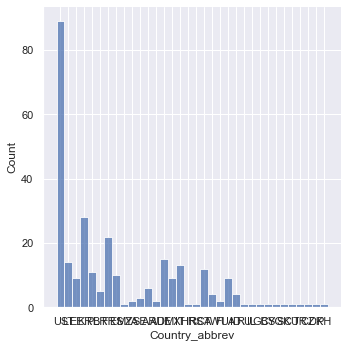

In [24]:
sns.displot(data=user_data, x="Country_abbrev")
plt.show()

In [27]:
# Merge Tables
# 1. Activity - commnuity
user_merge = activity_data.set_index("fk_User_id").join(user_data.set_index("User_id"), how='inner')
user_merge.index.name = "User_id"
display(user_merge.head())

pet_merge = pets_data.set_index("Pets_category").join(pet_cat_data.set_index("category_id"),how = 'inner')
pet_merge.index.name = "Pet_category"
pet_merge = pet_merge.reset_index().set_index("Pet_id")
display(pet_merge.head())

,Activity_Id,fk_Pet_id,VR_loading_time,duration_activity,log_id_act,First_Name,Last_Name,Address,Age,Gender,Rehabilitation,Zipcode,Country,Country_abbrev,Continent
User_id,,,,,,,,,,,,,,,
1,83,318,120.1,2.3,1521,Aiden,Hodkiewicz,"34795 Modesta Vista Suite 993\r\nEast Bailey, ...",26,1,1,26547,United States,US,NA
1,2051,298,29.0,5.2,846,Aiden,Hodkiewicz,"34795 Modesta Vista Suite 993\r\nEast Bailey, ...",26,1,1,26547,United States,US,NA
1,2185,21,50.4,8.3,981,Aiden,Hodkiewicz,"34795 Modesta Vista Suite 993\r\nEast Bailey, ...",26,1,1,26547,United States,US,NA
1,2489,334,30.2,1.1,2266,Aiden,Hodkiewicz,"34795 Modesta Vista Suite 993\r\nEast Bailey, ...",26,1,1,26547,United States,US,NA
1,2889,77,41.0,4.5,821,Aiden,Hodkiewicz,"34795 Modesta Vista Suite 993\r\nEast Bailey, ...",26,1,1,26547,United States,US,NA


,Pet_category,pet_User_id,Pet_Name,Pet_intimacy,category_name
Pet_id,,,,,
2,1,71,Conrad Ratke PhD,7.6,'Bulldog'
4,1,193,Michele Jacobs,0.8,'Bulldog'
13,1,88,Caden Franecki,2.4,'Bulldog'
15,1,65,Freda O'Kon,8.0,'Bulldog'
27,1,67,Marcel Hamill,8.1,'Bulldog'


# ----- above code is modified on Feb 17th -----

In [ ]:
# Data Cleaning process
cols = ["Have diseases", "Bmi (17-32)",	"Height(m)",	"weight(kg)",	"Age (20-80)",	"Gender", "Walk dog time (hr) (0-100)",	"Play time (hrs) (0-50)",	"Total steps",	"Calories", "Recovery"]
data = data[cols]

In [ ]:
# Logistic Model
input = data.loc[:, 'Have diseases':"Recovery"]
target = data[["Recovery"]]

X, y = input, target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [ ]:
iterations_n = 1000
learning_rate = 0.01
num_feature = len(cols)

In [ ]:
class PytorchLRModel(nn.Module):
    def __init__(self, num_feature):
        super(PytorchLRModel, self).__init__()
        self.fc1 = nn.Linear(num_feature, 2)
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x[:,1]

clf = PytorchLRModel(num_feature)
criterion = nn.BCELoss()

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(clf.parameters(), lr=learning_rate)
input = Variable(torch.Tensor(X_train.values))
target = Variable(torch.Tensor(y_train.values)).long()

clf.train()
for iter_ in range(iterations_n):
  optimizer.zero_grad()
  scores = clf(input)
  loss = criterion(scores.unsqueeze(1), target.float())
  loss.backward()
  optimizer.step()

  if iter_ % 100 == 0:
    print('Iteration {}, Loss: {}'.format(iter_, loss.data.cpu().numpy()))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration 0, Loss: 52.380950927734375
Iteration 100, Loss: 52.380950927734375
Iteration 200, Loss: 52.380950927734375
Iteration 300, Loss: 52.380950927734375
Iteration 400, Loss: 52.380950927734375
Iteration 500, Loss: 52.380950927734375
Iteration 600, Loss: 52.380950927734375
Iteration 700, Loss: 52.380950927734375
Iteration 800, Loss: 52.380950927734375
Iteration 900, Loss: 52.380950927734375


In [ ]:
clf.eval()
target = Variable(torch.Tensor(y_test.values)).long()
y_hat = clf(Variable(torch.Tensor(X_test.values)))
predictions = (y_hat >= 0.5).float()
print(predictions)
print(target.shape)
accuracy = torch.eq(predictions, target).sum().item() / target.size()[0]
print("Accuracy: ", accuracy)

tensor([0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([8, 1])
Accuracy:  5.0


In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth = 8, random_state = 18).fit(X_train, y_train)
prediction = rf.predict(X_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5
print(mse)
print(rmse)

0.058571500000000006
0.2420154953716807


In [ ]:
# Neural Network
class NN():
    def __init__(self, input_n, layers=[256,128], output_n, lr, iterations):
        self.input_layer = input_n
        self.output_layer = output_n
        self.fc1 = nn.Linear(self.input_layer, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], self.output_layer)

        self.lr = lr
        self.iterations = iterations
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class NN_train_test():
    def __init__(self, input_n, layers, output_n, lr， iterations, num_epochs):
        self.model = NN(input_n=input_n, layers=layers, output_n=output_n, lr=lr, iterations=iterations)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(),lr=lr)
        self.num_epochs = num_epochs
    def train(X, y):
        for epoch in range(self.num_epochs):
            correct = 0
            l = 0
            for i in range(X.shape[0]):
                data = X.iloc[i, :]
                result = y.iloc[i, :]
                prediction = self.model(data)
                loss = self.criterion(prediction, result)
                loss.backward()
                optimizer.step()

                _, predictions = prediction.max(dim=1)
                correct += torch.eq(predictions, result).sum().item()
                l += result.shape[0]
            accuracy = correct / l
            print("Epoch: {}, Accuracy: {}".format(epoch, accuracy))

    def test(X, y):
        pass

In [ ]:
# RNN
